# Proximal Policy Optimization

## Hyperparameters

In [1]:
from utils.hyperparameters import Config

config = Config()

# meta info
config.algo = 'ppo'
config.env_id = 'BreakoutNoFrameskip-v4'
config.seed = None
config.inference = False
config.print_threshold = 10
config.save_threshold = 100
config.render = False

# preprocessing
config.stack_frames = 4
config.adaptive_repeat = [4]
config.s_norm = 255.0
config.sticky_actions = 0.0

# Learning Control Variables
config.max_tsteps  = int(1e7)
config.learn_start = 0
config.num_envs    = 8
config.update_freq = 128
config.lr          = 2.5e-4
config.use_lr_schedule = True
config.grad_norm_max = 0.5
config.gamma = 0.99

# Adam Params
config.adam_eps = 1e-5

#Recurrent control
config.recurrent_policy_gradient = False
config.gru_size = 512

# A2C Controls
config.entropy_coef=0.01
config.value_loss_weight=0.5

# GAE Controls
config.use_gae = True
config.gae_tau = 0.95

#PPO controls
config.ppo_epoch = 4
config.ppo_mini_batch = 4
config.ppo_clip_param = 0.1
config.use_ppo_vf_clip = False
config.anneal_ppo_clip = True

## Rollout Storage

In [2]:
import torch
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from utils.RolloutStorage import RolloutStorage as Storage

class RolloutStorage(Storage):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, state_size, device, USE_GAE=True, gae_tau=0.95):
        super(RolloutStorage, self).__init__(num_steps, num_processes, obs_shape, action_space, state_size, device, USE_GAE, gae_tau)

    def feed_forward_generator(self, advantages, num_mini_batch):
        num_steps, num_processes = self.rewards.size()[0:2]
        batch_size = num_processes * num_steps
        assert batch_size >= num_mini_batch, (
            f"PPO requires the number processes ({num_processes}) "
            f"* number of steps ({num_steps}) = {num_processes * num_steps} "
            f"to be greater than or equal to the number of PPO mini batches ({num_mini_batch}).")
        mini_batch_size = batch_size // num_mini_batch
        sampler = BatchSampler(SubsetRandomSampler(range(batch_size)), mini_batch_size, drop_last=False)
        for indices in sampler:
            observations_batch = self.observations[:-1].view(-1,
                                        *self.observations.size()[2:])[indices]
            states_batch = self.states[:-1].view(-1, self.states.size(-1))[indices]
            actions_batch = self.actions.view(-1, self.actions.size(-1))[indices]
            value_preds_batch = self.value_preds[:-1].view(-1, 1)[indices]
            return_batch = self.returns[:-1].view(-1, 1)[indices]
            masks_batch = self.masks[:-1].view(-1, 1)[indices]
            old_action_log_probs_batch = self.action_log_probs.view(-1, 1)[indices]
            adv_targ = advantages.view(-1, 1)[indices]

            yield observations_batch, states_batch, \
                actions_batch, value_preds_batch, return_batch, masks_batch, \
                old_action_log_probs_batch, adv_targ

    def recurrent_generator(self, advantages, num_mini_batch):
        num_processes = self.rewards.size(1)
        assert num_processes >= num_mini_batch, (
            f"PPO requires the number processes ({num_processes}) "
            f"to be greater than or equal to the number of PPO mini batches ({num_mini_batch}).")
        num_envs_per_batch = num_processes // num_mini_batch
        perm = torch.randperm(num_processes)
        for start_ind in range(0, num_processes, num_envs_per_batch):
            observations_batch = []
            states_batch = []
            actions_batch = []
            value_preds_batch = []
            return_batch = []
            masks_batch = []
            old_action_log_probs_batch = []
            adv_targ = []

            for offset in range(num_envs_per_batch):
                ind = perm[start_ind + offset]
                observations_batch.append(self.observations[:-1, ind])
                states_batch.append(self.states[0:1, ind])
                actions_batch.append(self.actions[:, ind])
                value_preds_batch.append(self.value_preds[:-1, ind])
                return_batch.append(self.returns[:-1, ind])
                masks_batch.append(self.masks[:-1, ind])
                old_action_log_probs_batch.append(self.action_log_probs[:, ind])
                adv_targ.append(advantages[:, ind])

            T, N = self.num_steps, num_envs_per_batch
            # These are all tensors of size (T, N, -1)
            observations_batch = torch.stack(observations_batch, 1)
            actions_batch = torch.stack(actions_batch, 1)
            value_preds_batch = torch.stack(value_preds_batch, 1)
            return_batch = torch.stack(return_batch, 1)
            masks_batch = torch.stack(masks_batch, 1)
            old_action_log_probs_batch = torch.stack(old_action_log_probs_batch, 1)
            adv_targ = torch.stack(adv_targ, 1)

            # States is just a (N, -1) tensor
            states_batch = torch.stack(states_batch, 1).view(N, -1)

            # Flatten the (T, N, ...) tensors to (T * N, ...)
            observations_batch = _flatten_helper(T, N, observations_batch)
            actions_batch = _flatten_helper(T, N, actions_batch)
            value_preds_batch = _flatten_helper(T, N, value_preds_batch)
            return_batch = _flatten_helper(T, N, return_batch)
            masks_batch = _flatten_helper(T, N, masks_batch)
            old_action_log_probs_batch = _flatten_helper(T, N, \
                    old_action_log_probs_batch)
            adv_targ = _flatten_helper(T, N, adv_targ)

            yield observations_batch, states_batch, \
                actions_batch, value_preds_batch, return_batch, masks_batch, \
                old_action_log_probs_batch, adv_targ

## Agent

In [3]:
import torch.optim as optim
import numpy as np
from agents.A2C import Agent as A2C
from utils import LinearSchedule

class Agent(A2C):
    def __init__(self, env=None, config=None, log_dir='/tmp/gym', tb_writer=None):
        super(Agent, self).__init__(env, config, log_dir, tb_writer=tb_writer)

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.config.lr, eps=self.config.adam_eps)
        
        if self.config.anneal_ppo_clip:
            self.anneal_clip_param_fun = LinearSchedule(self.config.ppo_clip_param, 0.0, 1.0, config.max_tsteps)
        else:
            self.anneal_clip_param_fun = LinearSchedule(self.config.ppo_clip_param, None, 1.0, config.max_tsteps)
            
        self.rollouts = RolloutStorage(self.config.update_freq , self.config.num_envs,
            self.num_feats, self.envs.action_space, self.q_net.state_size,
            self.device, config.use_gae, config.gae_tau)

    def compute_loss(self, sample, next_value, clip_param):
        observations_batch, states_batch, actions_batch, value_preds_batch, return_batch, masks_batch, old_action_log_probs_batch, adv_targ = sample

        values, action_log_probs, dist_entropy, states = self.evaluate_actions(observations_batch,
                                                            actions_batch,
                                                            states_batch,
                                                            masks_batch)

        ratio = torch.exp(action_log_probs - old_action_log_probs_batch)
        surr1 = ratio * adv_targ
        surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * adv_targ
        action_loss = -torch.min(surr1, surr2).mean()

        if self.config.use_ppo_vf_clip:
            value_pred_clipped = value_preds_batch + (values - value_preds_batch).clamp(-clip_param, clip_param)
            value_losses = (values - return_batch).pow(2)
            value_losses_clipped = (value_pred_clipped - return_batch).pow(2)
            value_loss = torch.max(value_losses, value_losses_clipped).mul(0.5).mean()
        else:
            value_loss = (return_batch - values).pow(2).mul(0.5).mean()

        loss = action_loss + self.config.value_loss_weight * value_loss
        loss -= self.config.entropy_coef * dist_entropy

        return loss, action_loss, value_loss, dist_entropy

    def update_(self, rollout, next_value, tstep):
        rollout.compute_returns(next_value, self.config.gamma)

        advantages = rollout.returns[:-1] - rollout.value_preds[:-1]
        advantages = (advantages - advantages.mean()) / (
            advantages.std() + 1e-5)

        value_loss_epoch = 0
        action_loss_epoch = 0
        dist_entropy_epoch = 0

        clip_param = self.anneal_clip_param_fun(tstep)

        all_grad_norms = []
        all_sigma_norms = []

        for e in range(self.config.ppo_epoch):
            if self.q_net.use_gru:
                data_generator = rollout.recurrent_generator(
                    advantages, self.config.ppo_mini_batch)
            else:
                data_generator = rollout.feed_forward_generator(
                    advantages, self.config.ppo_mini_batch)


            for sample in data_generator:
                loss, action_loss, value_loss, dist_entropy = self.compute_loss(sample, next_value, clip_param)

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), self.config.grad_norm_max)
                self.optimizer.step()

                with torch.no_grad():
                    grad_norm = 0.
                    for p in self.q_net.parameters():
                        param_norm = p.grad.data.norm(2)
                        grad_norm += param_norm.item() ** 2
                    grad_norm = grad_norm ** (1./2.)
                    all_grad_norms.append(grad_norm)

                    if self.config.noisy_nets:
                        sigma_norm = 0.
                        for name, p in self.q_net.named_parameters():
                            if p.requires_grad and 'sigma' in name:
                                param_norm = p.data.norm(2)
                                sigma_norm += param_norm.item() ** 2
                        sigma_norm = sigma_norm ** (1./2.)
                        all_sigma_norms.append(sigma_norm)

                value_loss_epoch += value_loss.item()
                action_loss_epoch += action_loss.item()
                dist_entropy_epoch += dist_entropy.item()
        
        value_loss_epoch /= (self.config.ppo_epoch * self.config.ppo_mini_batch)
        action_loss_epoch /= (self.config.ppo_epoch * self.config.ppo_mini_batch)
        dist_entropy_epoch /= (self.config.ppo_epoch * self.config.ppo_mini_batch)
        total_loss = value_loss_epoch + action_loss_epoch + dist_entropy_epoch

        self.tb_writer.add_scalar('Loss/Total Loss', total_loss, tstep)
        self.tb_writer.add_scalar('Loss/Policy Loss', action_loss_epoch, tstep)
        self.tb_writer.add_scalar('Loss/Value Loss', value_loss_epoch, tstep)
        self.tb_writer.add_scalar('Loss/Forward Dynamics Loss', 0., tstep)
        self.tb_writer.add_scalar('Loss/Inverse Dynamics Loss', 0., tstep)
        self.tb_writer.add_scalar('Policy/Entropy', dist_entropy_epoch, tstep)
        self.tb_writer.add_scalar('Policy/Value Estimate', 0, tstep)
        if all_sigma_norms:
            self.tb_writer.add_scalar('Policy/Sigma Norm', np.mean(all_sigma_norms), tstep)
        self.tb_writer.add_scalar('Learning/Learning Rate', np.mean([param_group['lr'] for param_group in self.optimizer.param_groups]), tstep)
        self.tb_writer.add_scalar('Learning/Grad Norm', np.mean(all_grad_norms), tstep)

        return value_loss_epoch, action_loss_epoch, dist_entropy_epoch, 0.

## Training Loop

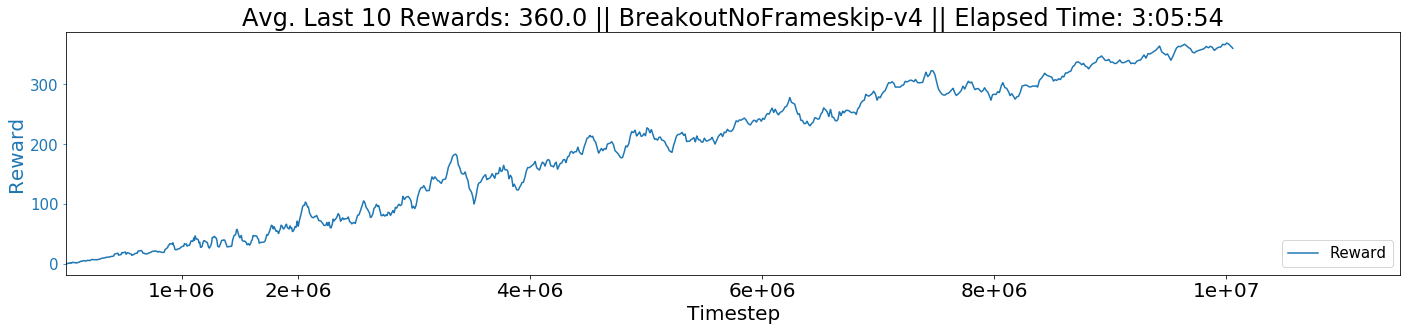

In [4]:
from train import train 
%matplotlib inline

train(config, Agent, ipynb=True)